In [14]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [15]:
img_size = 96
epochs = 75
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23
print(seed)

data_dir = "CK+MF/Male"

23


In [16]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split=testsplit,
        preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       subset="training"
)
val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)

Found 305 images belonging to 7 classes.
Found 72 images belonging to 7 classes.


In [17]:
from tensorflow.keras.callbacks import *
checkpoint = ModelCheckpoint('DNetCK+Malemodel.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq=1)

In [18]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

# Custom Layers neccesarry to acheive high acurracy 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


In [19]:
# Check data generators
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")

# Check class indices
print(f"Training class indices: {train_generator.class_indices}")
print(f"Validation class indices: {val_generator.class_indices}")

# Check model summary
model.summary()

# Ensure correct optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure ModelCheckpoint is correctly configured used for callback to save the best value based on val_accuracy
checkpoint = ModelCheckpoint('DNetCK+Malemodel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=75,
    callbacks=[checkpoint]
)

Number of training samples: 7
Number of validation samples: 2
Training class indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}
Validation class indices: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'sadness': 5, 'surprise': 6}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 96, 96, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 102, 102, 3)       │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 48, 48, 64)        │           9,408 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 48, 48, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 48, 48, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_3              │ (None, 50, 50, 64)        │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 24, 24, 64)        │               0 │ zero_padding2d_3[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 24, 24, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 24, 24, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 24, 24, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 24, 24, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 24, 24, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 24, 24, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 24, 24, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,735,111 (29.51 MB)

 Trainable params: 7,647,623 (29.17 MB)

 Non-trainable params: 87,488 (341.75 KB)

Epoch 1/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1663 - loss: 5.5272
Epoch 1: val_accuracy improved from -inf to 0.23611, saving model to DNetCK+Malemodel.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.1656 - loss: 5.5788 - val_accuracy: 0.2361 - val_loss: 3.7740
Epoch 2/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2240 - loss: 5.4189
Epoch 2: val_accuracy did not improve from 0.23611
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2279 - loss: 5.4685 - val_accuracy: 0.2361 - val_loss: 4.1110
Epoch 3/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3298 - loss: 5.7752
Epoch 3: val_accuracy did not improve from 0.23611
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3287 - loss: 5.7661 - val_accuracy: 0.2361 - val_loss: 4.3499
Epoch 4/75
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3472 - loss: 5.2275
Epoch 4: val_accuracy did not improve from 0.23611
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3513 - loss: 5.2750 - val_accuracy: 0.236

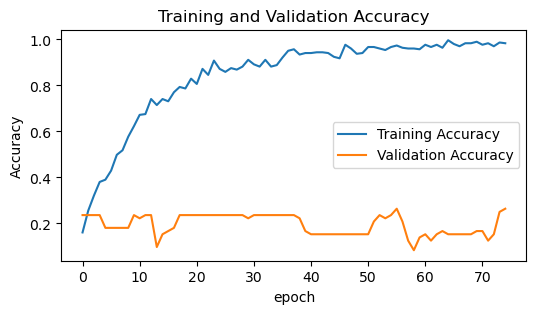

In [20]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

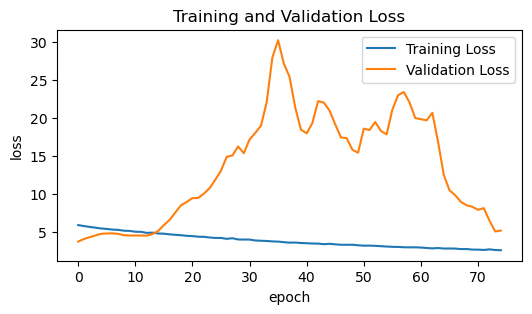

In [21]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [22]:
import tensorflow as tf
model =tf.keras.models.load_model('DNetCK+Malemodel.keras')
predictions = model.predict(val_generator, steps=len(val_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator.classes, y_pred=y, target_names=val_generator.class_indices)
print(cr)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Classification Report
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        11
    contempt       0.00      0.00      0.00         3
     disgust       0.24      1.00      0.38        17
        fear       0.00      0.00      0.00         4
       happy       0.00      0.00      0.00        13
     sadness       0.00      0.00      0.00         6
    surprise       0.00      0.00      0.00        18

    accuracy                           0.24        72
   macro avg       0.03      0.14      0.05        72
weighted avg       0.06      0.24      0.09        72



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


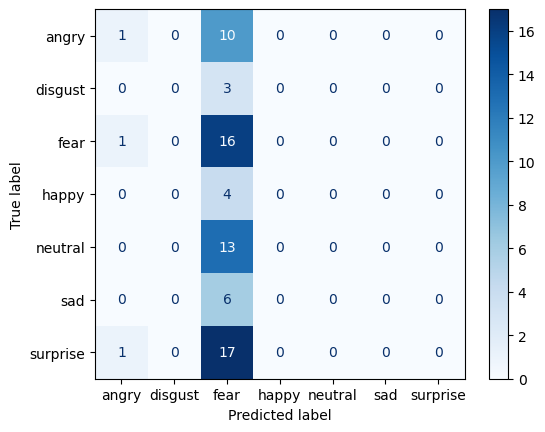

In [23]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

labels=['angry','disgust','fear','happy','neutral','sad','surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [24]:

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('32_21.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

NameError: name 'preprocess_image' is not defined

In [ ]:

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('PrivateTest_20588149.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot